In [2]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
from scipy import stats
import matplotlib.mlab as mlab
import os
from scipy.stats import norm
from scipy.optimize import curve_fit

from astropy.stats import sigma_clip
%matplotlib inline
sns.set()


In [32]:

plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
def array(name,x,y,a,b):
    filelist = glob(name)
    
    #set empty arrays to be filled
    mean_array = []
    std_array = []
    temp_array = []
    exp_array = []
    
    #goes through each image and gets the information
    for file in filelist:
        image = fits.open(file)
        
        mean = (image[0].data[x:y,a:b]).mean()
        mean_array.append(mean)
        
        std = (image[0].data[x:y,a:b]).std()
        std_array.append(std)
        
        temperature = image[0].header['CCD-TEMP']
        temp_array.append(temperature)
        
        time = image [0].header['EXPTIME']
        exp_array.append (time)
        
        
    return mean_array, std_array, temp_array, exp_array

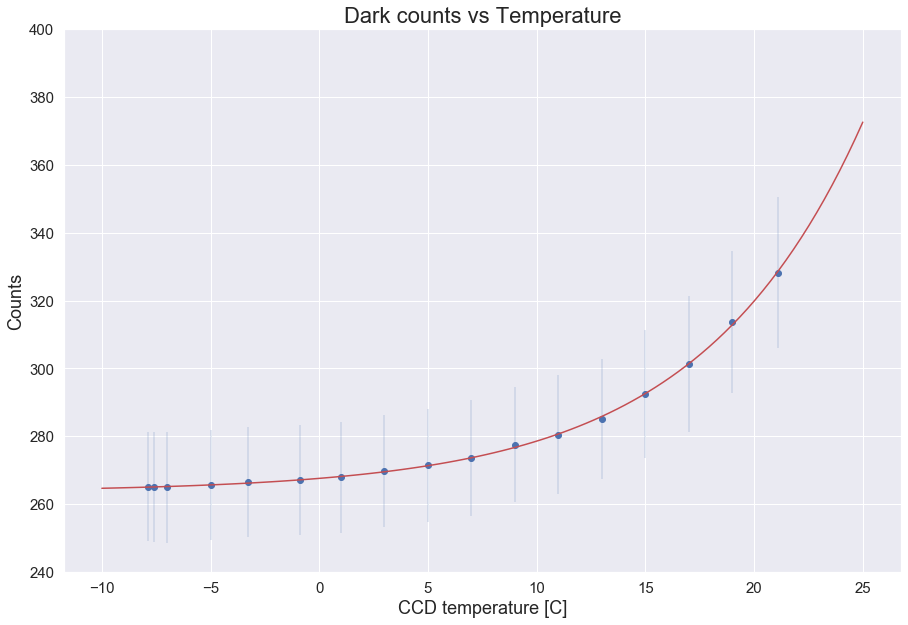

In [33]:

#sets the directory to he dark counts
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/darks/dark10')

#an exponential function is defined to fit the graph 
def e(x,a,b,c):
    return a*np.exp(b*x) +c


dark = array('dark10s*',451,500, 651, 750)

# getting the curve fit to plot the lin of best fit 
par, var =curve_fit(e, dark[2], dark[0], p0 =[4,0.07,300], sigma = dark[1], absolute_sigma=True)

#xvalues for line of best fit
x_t = np.linspace(-10,25,100)

#y values for line of best fit
yfit_e = e(x_t,*par)

#plotting error bars 
plt.errorbar(dark[2], dark[0], yerr=dark[1], ls='None', alpha=0.2)
plt.scatter(dark[2], dark[0],color = 'b' ,marker='o');
plt.plot(x_t,yfit_e, 'r')
plt.xlabel("CCD temperature [C]",fontsize=18)
plt.ylabel("Counts",fontsize=18)
plt.ylim(240,400)
plt.title('Dark counts vs Temperature', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()



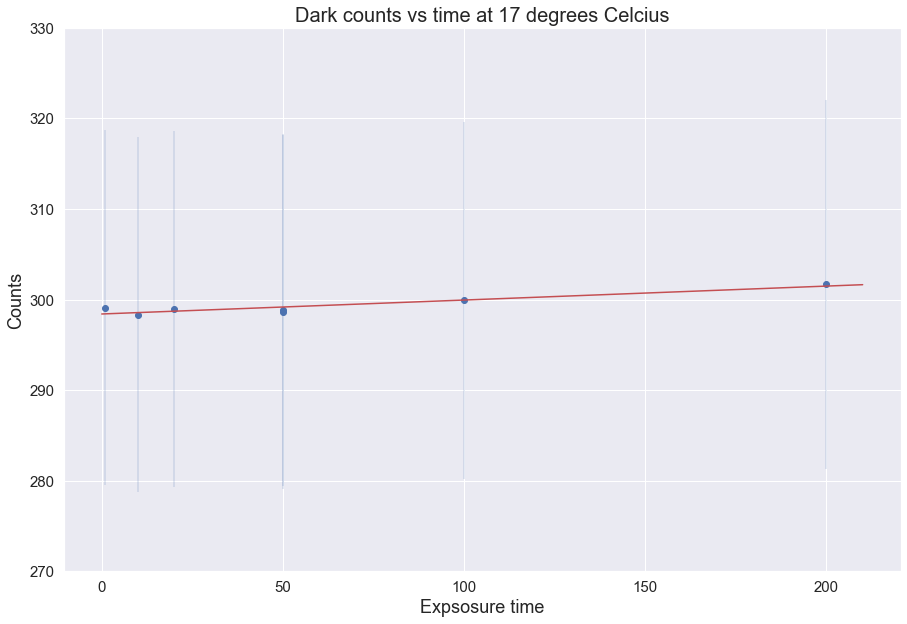

The slope = 1.540e-02 with error 2.681e-03
The mean dark current is 1.540e-02 +/- 2.681e-03 electons/pixel/second


In [34]:
#changing the directory
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/darks/current/17')

#defining function for a linear fit
def func(x,m,c):
    return m*x +c

dc17 = array('c*',451,500, 651, 750)

par1, var1 =curve_fit(func, dc17[3],dc17[0], p0 =[0.015,300])
x_t1= np.linspace(0,210,100)
yfit = func(x_t1,*par1)


plt.errorbar(dc17[3], dc17[0], yerr=dc17[1], ls='None', alpha=0.2)
plt.scatter(dc17[3], dc17[0],color = 'b' ,marker='o');

plt.xlabel("Expsosure time",fontsize=18)
plt.ylabel("Counts",fontsize=18);
plt.plot(x_t1,yfit, 'r')
plt.ylim(270,330)
plt.title('Dark counts vs time at 17 degrees Celcius',fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

#slope and error on the slope using the co variance matrix
m = par1[0]
e_m =  np.sqrt(var1[0,0])

print(f'The slope = {m:.3e} with error {e_m:.3e}')
print(f'The mean dark current is {m:.3e} +/- {e_m:.3e} electons/pixel/second')

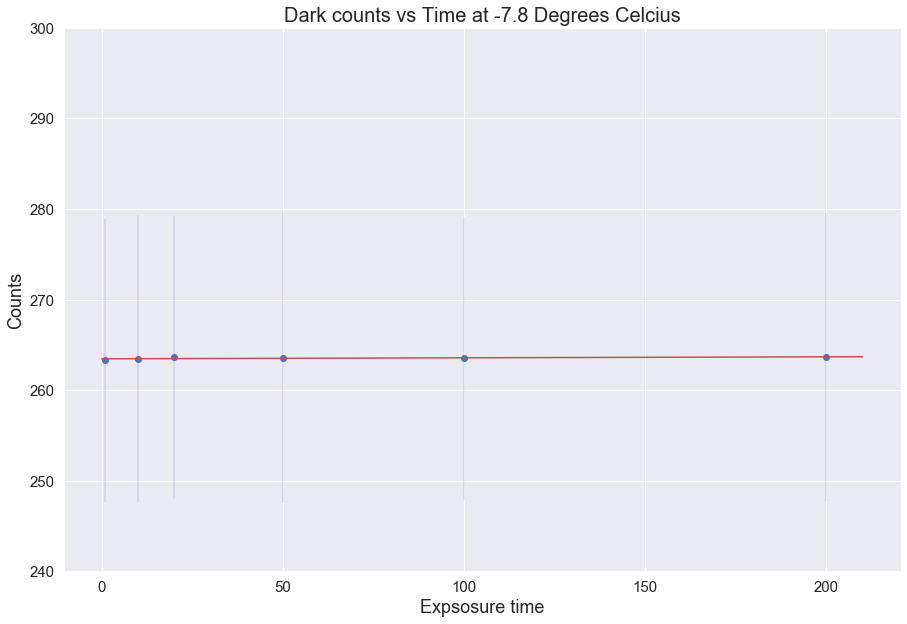

The slope = 1.091e-03 with error 6.326e-04


In [35]:
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/darks/current/-7.8')



dcn7 = array('c*',451,500, 651, 750)

par2, var2 =curve_fit(func, dcn7[3],dcn7[0], p0 =[0.015,300])

yfit2 = func(x_t1,*par2)




plt.errorbar(dcn7[3], dcn7[0], yerr=dcn7[1], ls='None', alpha=0.2)
plt.scatter(dcn7[3], dcn7[0],color = 'b' ,marker='o');

plt.xlabel("Expsosure time",fontsize=18)
plt.ylabel("Counts",fontsize=18)
plt.plot(x_t1,yfit2, 'r')
plt.ylim(240,300)
plt.title('Dark counts vs Time at -7.8 Degrees Celcius',fontsize=20)
plt.tick_params(labelsize=15)
plt.show()


m = par2[0]


e_m =  np.sqrt(var2[0,0])

print(f'The slope = {m:.3e} with error {e_m:.3e}')


In [13]:
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/flats')
x = array('flats*', 451,550,651,750)
#getting average at a central image
print(np.average(x[0]))
print(np.average(x[1]))

45077.574348535876
433.0821121404115


In [23]:
def sigmaclip(name, x, y, a, b, std): 
    
    filelist = glob(name)
    # to sigma clip the data, the data in each pixel must be obtained
    # get the data from all pixels and put them into a single list
    
    tot_data = []
    
    i = 0 
    
    while i < len(filelist):
        # using a loop to obtain data for all pixels 
        pdat = fits.open(filelist[i])[0].data[x:y, a:b]
        tot_data.append(pdat)
        i += 1
    
    #need to change data to array
    tot_datarray = np.asarray(tot_data)
    
    
    # the image data is a 3D array (n 2d arrays where n is the number of images and the arrays contain the pixel info)
    # since the data is in a two D array we need to flatten this so all the data is in a 1D array
    # we need to do this so we can sigma clip the data
    # tha axes are swapped suc that the concatenate function converts the data into a 2d array 
    # this 2D array has y 1D arrays containing the counts from pixels in the same position from each of the n images
    # (y = number of pixels)
   
    
    swapdata = np.swapaxes(tot_datarray,0,2)
    
    datatoclip = np.concatenate(swapdata) 
    
    
    #starting a new while loop to clip the pixel data
    
    k = 0  
    dataclipped = []

    while k < len(datatoclip):
        
        #using the imported sigma clip function....
        dataclipped.append(sigma_clip(datatoclip[k], sigma = std))
        k +=1
        
    #now to convert to an array
    clipdatarray = np.asarray(dataclipped)
    
    #in order to be able to create the masters we need to seperate the pixels back into there rows and columns
    #need to reverse the effects of the concatenate function - split array into x arrays
    # (x = number of rows/columns ie 200 x 200 - x = 200)
    # use len to get the number of pixel rows/columns - could use [1] or [2] in the total data at begining
    
    x = len(tot_datarray[0][1])
    clipsplit= np.array_split(clipdatarray,x)
    
    #swap axes back to origional

   
    clippedmaster = np.swapaxes(clipsplit, 2, 0)
    print(np.shape(clippedmaster))
    # now we just want one big image but we have 18 images
    # need to get the average counts of each pixel
    
    av = np.mean(clippedmaster,axis=0)
    # now just left with the average sigma clipped counts for the master
    
    
    return av
        

In [24]:
#combines all images into one master
def masterframe(name, x, y, a, b):
    
    i = 0 
    data = []
    lis = glob(name)
    while i < len(lis):
        
        pdat = fits.open(lis[i])[0].data[x:y, a:b]
        data.append(pdat)
        
        i += 1
    master = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    
    return master

(100, 99, 100)


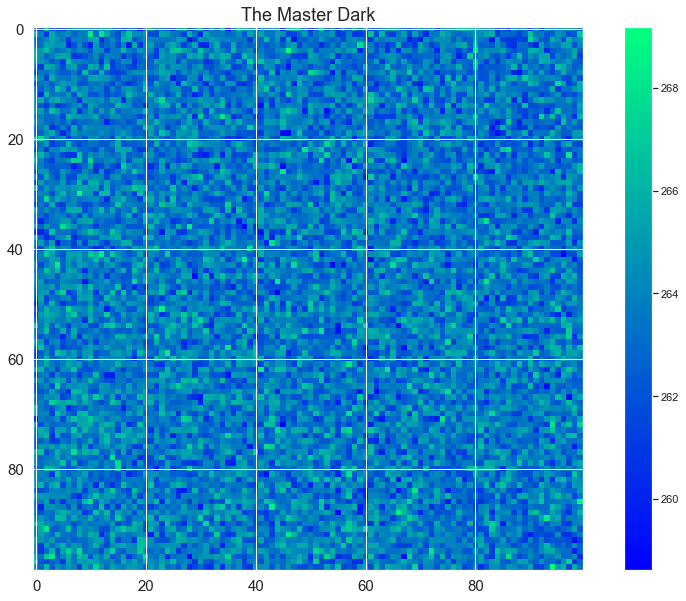

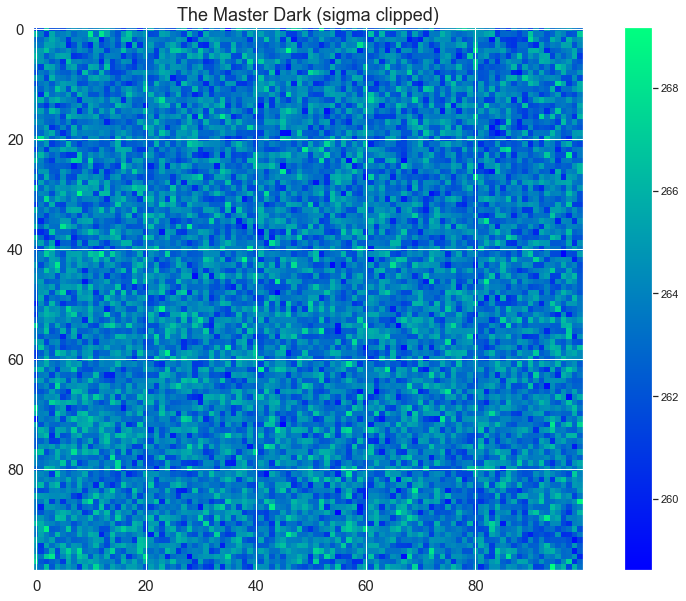

In [38]:
#creating the master dark
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/darks/master')

dark = masterframe('m*', 451, 550, 651,751) 

darka = sigmaclip('m*', 451, 550, 651,751,3) 

plt.imshow(dark, cmap = 'winter')
plt.title('The Master Dark', fontsize = 18)
plt.colorbar()
plt.tick_params(labelsize=15)
plt.show()

plt.imshow(darka, cmap = 'winter')
plt.title('The Master Dark (sigma clipped)', fontsize = 18)
plt.colorbar()
plt.tick_params(labelsize=15)
plt.show()



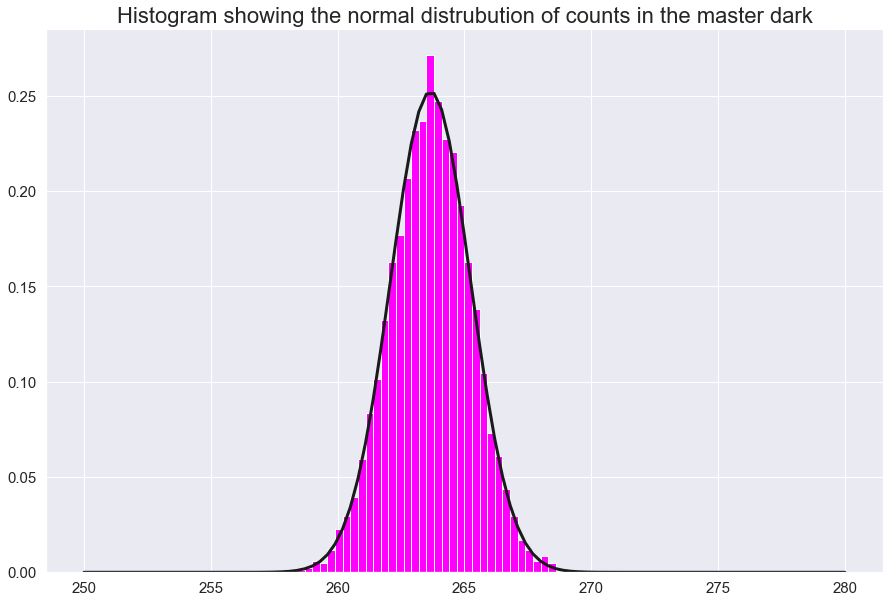

In [37]:
imagedark = np.ravel(dark)

#plotting the histogram
n, bins, patches = plt.hist(imagedark ,bins=100, range=(250,280), density=0.5, color='magenta')

m, std = stats.norm.fit(imagedark)

#need to make a gaussian curve to fit the datausing the mean and std
fit_y = norm.pdf( bins, m, std)
# Plot same
plt.plot(bins, fit_y, color="k", linewidth=3)

plt.title('Histogram showing the normal distrubution of counts in the master dark', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

In [29]:
#getting mean and standard deviation of the data set
m, std = stats.norm.fit(imagedark)
d = array('m*', 451, 550, 651,751)
print(m,np.mean(d[0]))


263.66243232323234 263.6624323232323


(100, 1039, 1391)


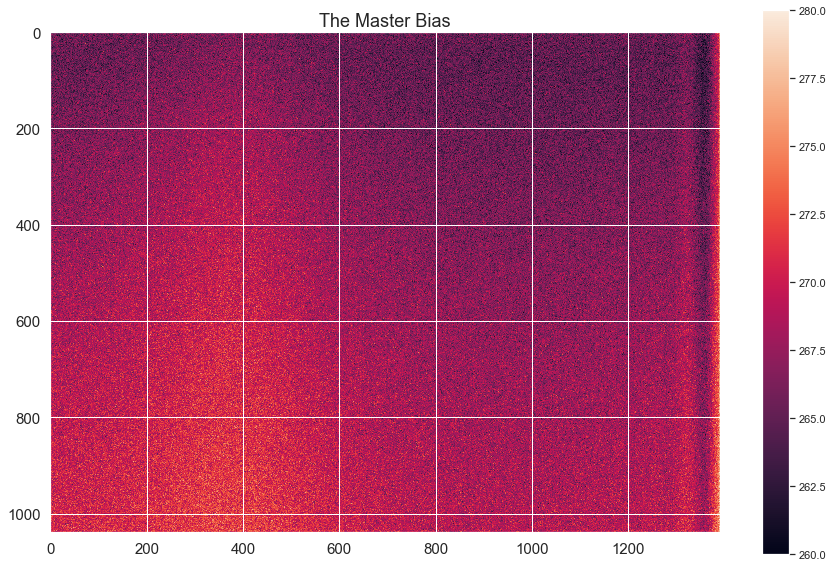

In [46]:
#creating the master bias
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/bias')
masterbias = sigmaclip('bias*', 0, 1039, 0, 1391, 3)

plt.imshow(masterbias, vmin= 260, vmax = 280)
plt.title('The Master Bias', fontsize = 18)
plt.tick_params(labelsize=15)
plt.colorbar()
plt.show()

(100, 1039, 1391)
0.9978437854729092


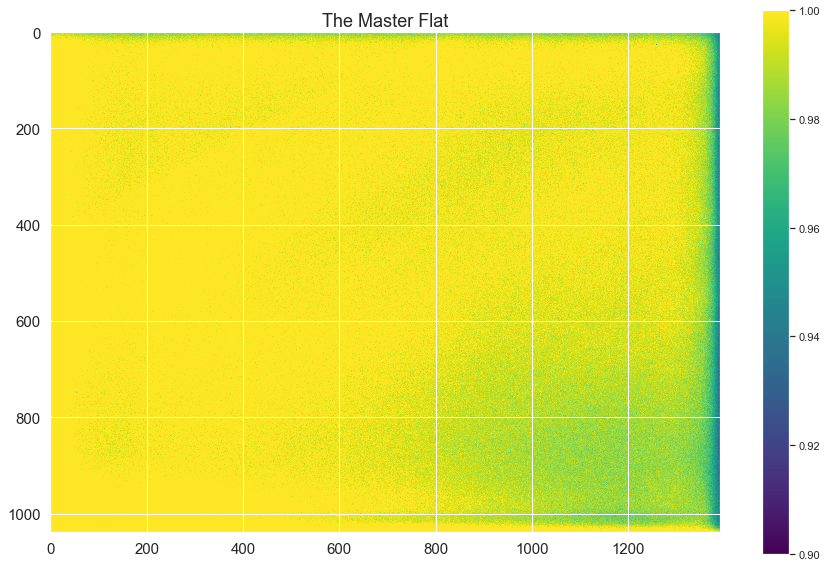

In [47]:
#creating the master flat
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/flats')
flat = sigmaclip('flats*',  0, 1039, 0, 1391, 3)
masterflat = (flat - masterbias)/44800
print(np.mean(masterflat))

plt.imshow(masterflat, vmin = 0.9, vmax = 1, cmap = 'viridis')
plt.title('The Master Flat', fontsize = 18)
plt.tick_params(labelsize=15)
plt.colorbar()
plt.show()

In [58]:
#gain and readout noise calibrations
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/flats')
flat1 = fits.open('flats001.fit')
flat2 = fits.open('flats002.fit')

#need to change from integers to floats
# need to have negative differnece and not possible with ints - gets errors in the arrays
flat1dat= (flat1[0].data[451:550,651:750]).astype(float)
flat2dat= (flat2[0].data[451:550,651:750]).astype(float)


    
flatdif = flat1dat - flat2dat

fsig = flatdif.std()

print('std of flats diff is:', fsig)

#change dir
os.chdir(r'C:/Users/laura/Documents/3rd year/Astro labs/CCDs/CCDdat/bias')

bias1 = fits.open('bias001.fit')
bias2 = fits.open('bias002.fit')

bias1dat= (bias1[0].data[451:550,651:750]).astype(float)
bias2dat= (bias2[0].data[451:550,651:750]).astype(float)


biasdif = (bias1dat - bias2dat)



bsig = biasdif.std()

print('std of bias diff is:',bsig)


#calculate the gain

g = ((flat1dat.mean()+flat2dat.mean()) - (bias1dat.mean()+bias2dat.mean()))/(fsig**2 - bsig**2)
print('Gain is:', g)

read = g*(bsig/np.sqrt(2))

print('Readout noise is:', read)
e_g= np.sqrt((biasdif.mean()/bsig)**2 + (flatdif.mean()/fsig)**2)*g
e_r = np.sqrt((biasdif.mean()/bsig)**2 + (flatdif.mean()/fsig)**2)*read

print(e_g, e_r)

std of flats diff is: 572.8379783137354
std of bias diff is: 22.9202196586104
Gain is: 0.27394580550833003
Readout noise is: 4.439851380204344
0.009333682412644827 0.15127138984761732


In [56]:
#calculates the percentage of data in given standard deviations 
#compares to gaussian rules to test if data follows a gaussian distribution
def nd(mastername):
    dat = np.ravel(mastername)
    m, std = stats.norm.fit(dat)
    count1 = 0
    count2 = 0
    count3 = 0
    
    for i in dat:
        if i < (m - std) or i >  (m + std):
            count1 +=1
        if i < (m - 2*std) or i >  (m + 2*std):
            count2 += 1
        if i < (m - 3*std) or i >  (m + 3*std):
            count3 += 1

    print(1-count1/len(dat))
    print(1-count2/len(dat))
    print(1-count3/len(dat))


In [57]:
nd(masterbias)

0.6750283169197834
0.9583435103570388
0.997767166765035
